In [1]:
from skyfield.api import Topos, load

In [2]:
stations_url = 'http://celestrak.com/NORAD/elements/stations.txt'
satellites = load.tle(stations_url)
iss = satellites['ISS (ZARYA)']

planets = load('de421.bsp')
sun = planets['sun']
earth = planets['earth']

In [127]:
import warnings

# calculating and data containing
import numpy as np
from numpy import linalg as LA
import pandas as pd
import swifter

# time
from datetime import timezone, timedelta, datetime

# celestial bodies motion calculating
from skyfield.api import Topos, load
from skyfield.positionlib import Geocentric
from skyfield.nutationlib import iau2000b

# plotting
import os
os.environ['PROJ_LIB'] = r'C:\Users\Egor\AppData\Local\Continuum\anaconda2\pkgs\proj4-4.9.2-vc10_0\Library\share'
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import seaborn as sns

# multiprocessing
# from dask import dataframe as dd
# from multiprocessing import cpu_count, Pool
# import multiprocessing as mp
# from pandarallel import pandarallel
# pandarallel.initialize()

# constants
R_earth = 6371000 #m
R_sun = 1.392E9/2 #m

# visibility indexes
visible = {'false' : 0, 'true' : 1, 'up' : 2, 'down' : 3}

class image_plotter:
    def __init__(self, sat, sun, earth, dt=10, T=[3, 0, 0, 0], h=[20, 80], start_date=[2019, 12, 20, 0, 0, 0], GMT=0):
        self.sat = sat
        self.sun = sun
        self.earth = earth
        self.dt = dt
        self.T = T
        self.h = [h[0]*1E3, h[1]*1E3] # km -> m
        self.ts = load.timescale()
        self.start_date = start_date
        self.GMT = GMT

        times = self.get_dates()
        self.df = pd.DataFrame({'Date':times}) 
        
    def decode_start_date(self):
        Y = self.start_date[0]
        M = self.start_date[1]
        D = self.start_date[2]
        h = self.start_date[3]
        m = self.start_date[4]
        s = self.start_date[5]
        return Y, M, D, h, m, s
    
    def decode_period(self):
        dD = self.T[0]
        dh = self.T[1]
        dm = self.T[2]
        ds = self.T[3]
        return dD, dh, dm, ds      

    def get_dates(self):
        # start date
        Y, M, D, h, m, s = self.decode_start_date()        
        # period considered
        dD, dh, dm, ds = self.decode_period()

        # getting vector of dates
        ts = load.timescale()  # create skyfield timescale object
        tz = timezone(timedelta(hours=self.GMT))  # whatever your timezone offset from UTC is
        start = datetime(Y, M, D, h, m, s, tzinfo=tz)  # timezone-aware start time
        end = start + timedelta(seconds=ds, minutes=dm, hours=dh, days=dD)  # one day's worth of times
        delta = timedelta(seconds=self.dt)  # your interval over which you evaluate
        times = [start]
        now = start
        while now <= end:
            now += delta
            times.append(now)
        return times

    def get_sun_position(self, row):
        t = row["Date"]
        t = self.ts.utc(t) 
#         t._nutation_angles = iau2000b(t.tt)    # advise from 
        pos = self.earth.at(t).observe(self.sun).apparent().position.m 
        return pos
    
    def get_sat_position_carthesian_and_spherical(self, row):
        t = self.ts.utc(row["Date"])
        geocentric = self.sat.at(t)
        row["sat_pos"] = geocentric.position.m
        subpoint = geocentric.subpoint()
        row["sat_subpoint"] = np.array([self.convert_angle(subpoint.latitude), 
                                        self.convert_angle(subpoint.longitude), subpoint.elevation.m])
        return row 

    def get_sat_position(self, row):
        t = self.ts.utc(row["Date"])
        geocentric = self.sat.at(t)
        pos = geocentric.position.m
        return pos

    def get_positions(self):
#         self.df["sat_pos"] = self.df.swifter.apply(self.get_sat_position, axis=1)
        self.df = self.df.swifter.apply(self.get_sat_position_carthesian_and_spherical, axis=1)
        self.df["sun_pos"] = self.df.swifter.apply(self.get_sun_position, axis=1)
        
#         self.df["sat_pos"] = dd.from_pandas(self.df, npartitions=4*cpu_count())\
#             .map_partitions(lambda df : df.apply(lambda row : self.get_sat_position(row),axis=1))\
#                 .compute(scheduler='processes', serializer="msgpack", deserializers=['dask', 'msgpack'])
#         self.df["sun_pos"] = dd.from_pandas(self.df, npartitions=4*cpu_count())\
#             .map_partitions(lambda df : df.apply(lambda row : self.get_sun_position(row),axis=1))\
#                 .compute(scheduler='processes')
        
        self.df["sat_to_sun"] = self.df["sun_pos"] - self.df["sat_pos"] # vector between sat and sun, pointing to the sun


    def calculate_visibility(self):
        print("before", self.df.shape)
        self.df["sun_vis"] = self.df.swifter.apply(self.sun_is_visible, axis=1)
        self.df = self.df[self.df["sun_vis"]!=0]
        self.df = self.df.reset_index(drop=True)
        print("after", self.df.shape)

    def sun_is_visible(self, row):
        # radius-vectors of sat and sun
        r_sat = row["sat_pos"]
        r_sun = row["sun_pos"]
        r_ss = row["sat_to_sun"] 
        # getting modules
        r_sat = LA.norm(r_sat)
        r_sun = LA.norm(r_sun)
        r_ss = LA.norm(r_ss)
        # angles of visibility
        rho_up = np.arcsin((R_earth + self.h[1]) / r_sat)
        rho_down = np.arcsin((R_earth + self.h[0]) / r_sat)
        rho_sun = np.arcsin(R_sun / r_ss)
        d = np.arccos((r_sat**2 + r_ss**2 - r_sun**2) / (2 * r_sat * r_ss))
        # determing if sun is visible
        if rho_up >= d - rho_sun and rho_down <= d + rho_sun : return visible["true"]
        elif rho_up >= d - rho_sun and rho_down <= d - rho_sun : return visible["down"]
        elif rho_up >= d + rho_sun and rho_down <= d + rho_sun : return visible["up"]
        else : return visible["false"]  

    def get_entry_vec(self, row):   
        b1, b2, b3 = row["sat_to_sun"]
        c1, c2, c3 = row["sat_pos"]
        R = R_earth + self.h[1]
        # from Mathematica
        a1 = (-2*b1**2*c1 - 2*b1*b2*c2 - 2*b1*b3*c3 - np.sqrt((2*b1**2*c1 + 2*b1*b2*c2 + 2*b1*b3*c3)**2 - 4*(b1**2 + b2**2 + b3**2)*(b1**2*c1**2 + b1**2*c2**2 + b1**2*c3**2 - b1**2*R**2)))/(2.*(b1**2 + b2**2 + b3**2))
        a2 = (-((b1**2*b2*c1)/(b1**2 + b2**2 + b3**2)) - (b1*b2**2*c2)/(b1**2 + b2**2 + b3**2) - (b1*b2*b3*c3)/(b1**2 + b2**2 + b3**2) - (b2*np.sqrt((2*b1**2*c1 + 2*b1*b2*c2 + 2*b1*b3*c3)**2 - 4*(b1**2 + b2**2 + b3**2)*(b1**2*c1**2 + b1**2*c2**2 + b1**2*c3**2 - b1**2*R**2)))/(2.*(b1**2 + b2**2 + b3**2)))/b1
        a3 = (-((b1**2*b3*c1)/(b1**2 + b2**2 + b3**2)) - (b1*b2*b3*c2)/(b1**2 + b2**2 + b3**2) - (b1*b3**2*c3)/(b1**2 + b2**2 + b3**2) - (b3*np.sqrt((2*b1**2*c1 + 2*b1*b2*c2 + 2*b1*b3*c3)**2 - 4*(b1**2 + b2**2 + b3**2)*(b1**2*c1**2 + b1**2*c2**2 + b1**2*c3**2 - b1**2*R**2)))/(2.*(b1**2 + b2**2 + b3**2)))/b1
        if np.isnan(a1) or np.isnan(a2) or np.isnan(a3) : return np.nan
        else : return np.array([a1, a2, a3]) + row["sat_pos"]

    def get_exit_vec(self, row):
        b1, b2, b3 = row["sat_to_sun"]
        c1, c2, c3 = row["sat_pos"]
        R = R_earth + self.h[1]
        # from Mathematica
        a1 = (-2*b1**2*c1 - 2*b1*b2*c2 - 2*b1*b3*c3 + np.sqrt((2*b1**2*c1 + 2*b1*b2*c2 + 2*b1*b3*c3)**2 - 4*(b1**2 + b2**2 + b3**2)*(b1**2*c1**2 + b1**2*c2**2 + b1**2*c3**2 - b1**2*R**2)))/(2.*(b1**2 + b2**2 + b3**2))
        a2 = (-((b1**2*b2*c1)/(b1**2 + b2**2 + b3**2)) - (b1*b2**2*c2)/(b1**2 + b2**2 + b3**2) - (b1*b2*b3*c3)/(b1**2 + b2**2 + b3**2) + (b2*np.sqrt((2*b1**2*c1 + 2*b1*b2*c2 + 2*b1*b3*c3)**2 - 4*(b1**2 + b2**2 + b3**2)*(b1**2*c1**2 + b1**2*c2**2 + b1**2*c3**2 - b1**2*R**2)))/(2.*(b1**2 + b2**2 + b3**2)))/b1
        a3 = (-((b1**2*b3*c1)/(b1**2 + b2**2 + b3**2)) - (b1*b2*b3*c2)/(b1**2 + b2**2 + b3**2) - (b1*b3**2*c3)/(b1**2 + b2**2 + b3**2) + (b3*np.sqrt((2*b1**2*c1 + 2*b1*b2*c2 + 2*b1*b3*c3)**2 - 4*(b1**2 + b2**2 + b3**2)*(b1**2*c1**2 + b1**2*c2**2 + b1**2*c3**2 - b1**2*R**2)))/(2.*(b1**2 + b2**2 + b3**2)))/b1
        if np.isnan(a1) or np.isnan(a2) or np.isnan(a3) : return np.nan
        else : return np.array([a1, a2, a3]) + row["sat_pos"]
        
    def convert_angle(self, angle): # converts angle value from int(deg), int(min), int(sec) to float(deg)
        angle = angle.dms(warn=True)
        return angle[0] + angle[1] / 60 + angle[2] / 3600

    def beam_path_points_with_skyfield_angles(self, row):
        num_points = row["num_points"]
        points_skyfield = []
        points = []
        for i in range(num_points):
            point = row["entry_vec"] + row["diff"] * i
            point = Geocentric(position_au=point/149597870700, t=self.ts.utc(row["Date"]))
            subpoint = point.subpoint()
            points_skyfield.append([subpoint.latitude, subpoint.longitude, subpoint.elevation.m])
            points.append([self.convert_angle(subpoint.latitude), self.convert_angle(subpoint.longitude), subpoint.elevation.m])
            
        row["beam_path_points_with_skyfield_angles"] = np.array(points_skyfield)
        row["beam_path"] = np.array(points)
        return row


    def get_beam_path(self, num_points=50):
        # get vectors, pointing to the entry to atm and to the exit from atm of light beam
        self.df["entry_vec"] = self.df.swifter.apply(self.get_entry_vec, axis=1)
        self.df["exit_vec"] = self.df.swifter.apply(self.get_exit_vec, axis=1)
        self.df = self.df.dropna()

        # get points forming light trajectory
        self.df["diff"] = self.df["exit_vec"] - self.df["entry_vec"] 
        self.df["num_points"] = num_points
        self.df["diff"] /= self.df["num_points"] - 1
        self.df = self.df.swifter.apply(self.beam_path_points_with_skyfield_angles, axis=1)

        # clean data
        self.df.drop(columns=["diff"])
        self.df = self.df.reset_index(drop=True)
        
    def total_seconds(self, t):
        return t.total_seconds()
    
    def get_flyby_info(self, plot=True, lookup=True):
        self.df["dt"] = self.df["Date"].diff().apply(self.total_seconds)        
        Duration = []    
        Start = []
        End = []      
        for index, row in self.df.iterrows():
#             print(row)
            dt = row["dt"]
            date = row["Date"]
            if np.isnan(dt) : 
                Duration.append(0)  
                Start.append(date)
                End.append(date)
            elif dt <= 2 * self.dt : 
                Duration[-1] += dt
                if End[-1] < date : End[-1] = date
            else : 
                Duration.append(0)
                Start.append(date)
                End.append(date)
            
        assert len(Duration) == len(Start) and len(Duration) == len(End), print("Sizes of the lists must be equal! Duration", len(Duration), "Start", len(Start), "End", len(End))
        flyby_info = pd.DataFrame({"Duration" : Duration, "Start" : Start, "End" : End})  
        self.flyby_info = flyby_info
        
        if lookup : 
            flyby_info.head()
            print("Shape is ", flyby_info.shape)
            
        if plot :
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(12, 6)
            fig.suptitle('Flyby duration plots')
            ax1.plot(flyby_info["Duration"])
            ax1.set_xlabel("Number of flyby")
            ax1.set_ylabel("Duration of flyby, sec")

            ax2 = sns.distplot(flyby_info["Duration"])
            ax2.set_ylabel("Fraction")
            ax2.set_xlabel("Duration of flyby, sec")
        
        return flyby_info       
    
    def plot(self, terminator=False, sat_trajectory=False, save=False, projection='cyl'):
        # start date
        Y, M, D, h, m, s = self.decode_start_date()        
        # period considered
        dD, dh, dm, ds = self.decode_period()
        
        # datetimes
        tz = timezone(timedelta(hours=self.GMT))  # whatever your timezone offset from UTC is
        date = datetime(Y, M, D, h, m, s, tzinfo=tz)  # timezone-aware start time
        ddate = timedelta(days=dD, hours=dh, minutes=dm, seconds=ds)
        date_mid = date + ddate / 2
        print("Start date is", date)
        print("Middle date is", date_mid)
        print("Final date is", date + ddate)    

        # prepare data for plotting
        # beam path points
        ar = np.array(self.df["beam_path"][0])
        for i in self.df["beam_path"]:
            ar = np.concatenate((ar, i), axis=0)

        # satellite trajectory points 
        if sat_trajectory : 
            sat = np.array(self.df["sat_subpoint"][0])
            sat = sat[np.newaxis]
            for i in self.df["sat_subpoint"]:
                i = i[np.newaxis]
                sat = np.concatenate((sat, i), axis=0)
            
        # plotting
        # map
#         fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        fig = plt.figure(figsize=(12, 6), edgecolor='w')
        ax = fig.add_axes([0,0,1,1])
        mp = Basemap(projection=projection, lat_0=0, lon_0=0, ax=ax)

        # relief, water and etc.
        mp.drawcoastlines(color='gray', zorder=0)
        mp.shadedrelief(zorder=0)

        # plotting terminator
        if terminator : 
            term_speed = 360./(24*3600)
            total_sec = dD * 24 * 3600 + dh * 3600 + dm * 60 + ds
            print("During the considered time period, the terminator shifts by", term_speed * total_sec, "degrees.")
            print("Position of the terminator for the middle of the period is shown.")
            CS=mp.nightshade(date_mid, zorder=1)

        # plotting atmospheric cut 
        lons = ar[:, 1]
        lats = ar[:, 0]
        elev = ar[:, 2]
        x, y = mp(lons, lats)
        lol = mp.scatter(x, y, marker=".", c=elev/1000, cmap="plasma", s=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.2)
        cbar = fig.colorbar(lol, cax=cax)
        cbar.set_label('Beam elevation, km', rotation=90)

        # plotting sattelite trajectory
        if sat_trajectory : 
            lats = sat[:, 0]
            lons = sat[:, 1]
            elev = sat[:, 2]
            x, y = mp(lons, lats)
            lol = mp.scatter(x, y, marker=".", c=elev/1000, cmap="winter", s=1)

        # saving
        if save : plt.savefig('foo.png')
            
        # showing
        plt.show()
        
    def go(self):
        self.get_positions()
        self.calculate_visibility()
        self.get_flyby_info(plot=False) 
        self.get_beam_path(num_points=25)
        self.plot(terminator=True, sat_trajectory=True, save=False, projection='cyl')      
 

In [128]:
ip = image_plotter(iss, sun, earth, dt=5, T=[0, 0, 15, 0], h=[20, 80], start_date=[2020, 5, 15, 17, 13, 0])

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



before (182, 5)



after (156, 6)
Shape is  (1, 3)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p


Start date is 2020-05-15 17:13:00+00:00
Middle date is 2020-05-15 17:20:30+00:00
Final date is 2020-05-15 17:28:00+00:00
During the considered time period, the terminator shifts by 3.75 degrees.
Position of the terminator for the middle of the period is shown.


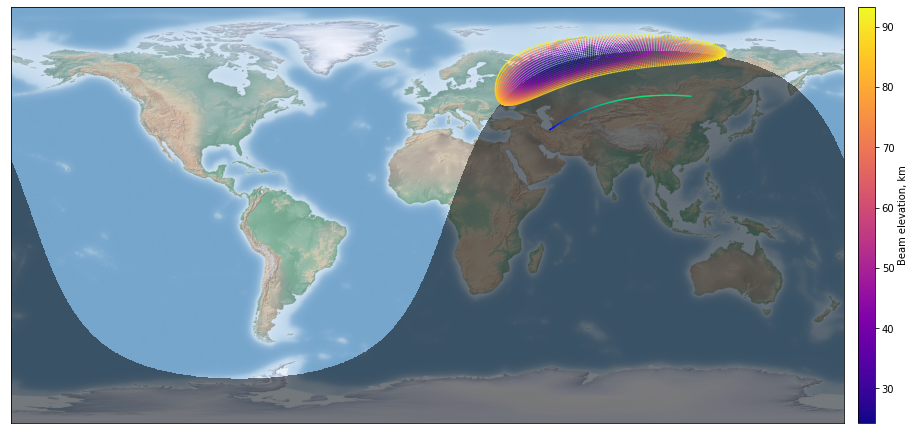

In [129]:
ip.go()

In [16]:
%%time
ip.get_positions()

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



Wall time: 3.22 s


In [17]:
%%time
ip.calculate_visibility()

before (452, 5)



after (390, 6)
Wall time: 122 ms


Shape is  (1, 3)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Duration,Start,End
0,779.0,2020-05-15 17:13:06+00:00,2020-05-15 17:26:05+00:00


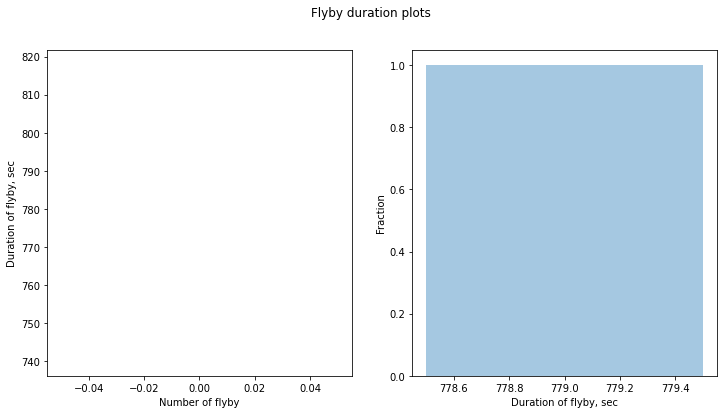

In [11]:
ip.get_flyby_info() 

In [12]:
%%time
ip.get_beam_path(num_points=50)

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p


Wall time: 27 s


## Plotting

Start date is 2020-05-15 17:13:00+00:00
Middle date is 2020-05-15 17:20:30+00:00
Final date is 2020-05-15 17:28:00+00:00
During the considered time period, the terminator shifts by 3.75 degrees.
Position of the terminator for the middle of the period is shown.


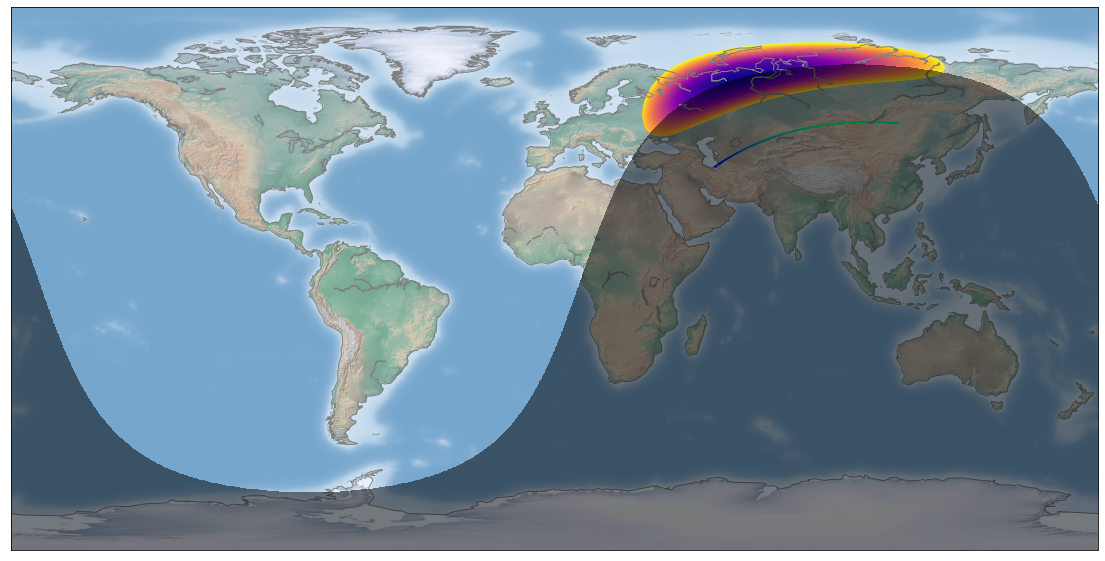

In [13]:
ip.plot(terminator=True, sat_trajectory=True, save=False)